In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

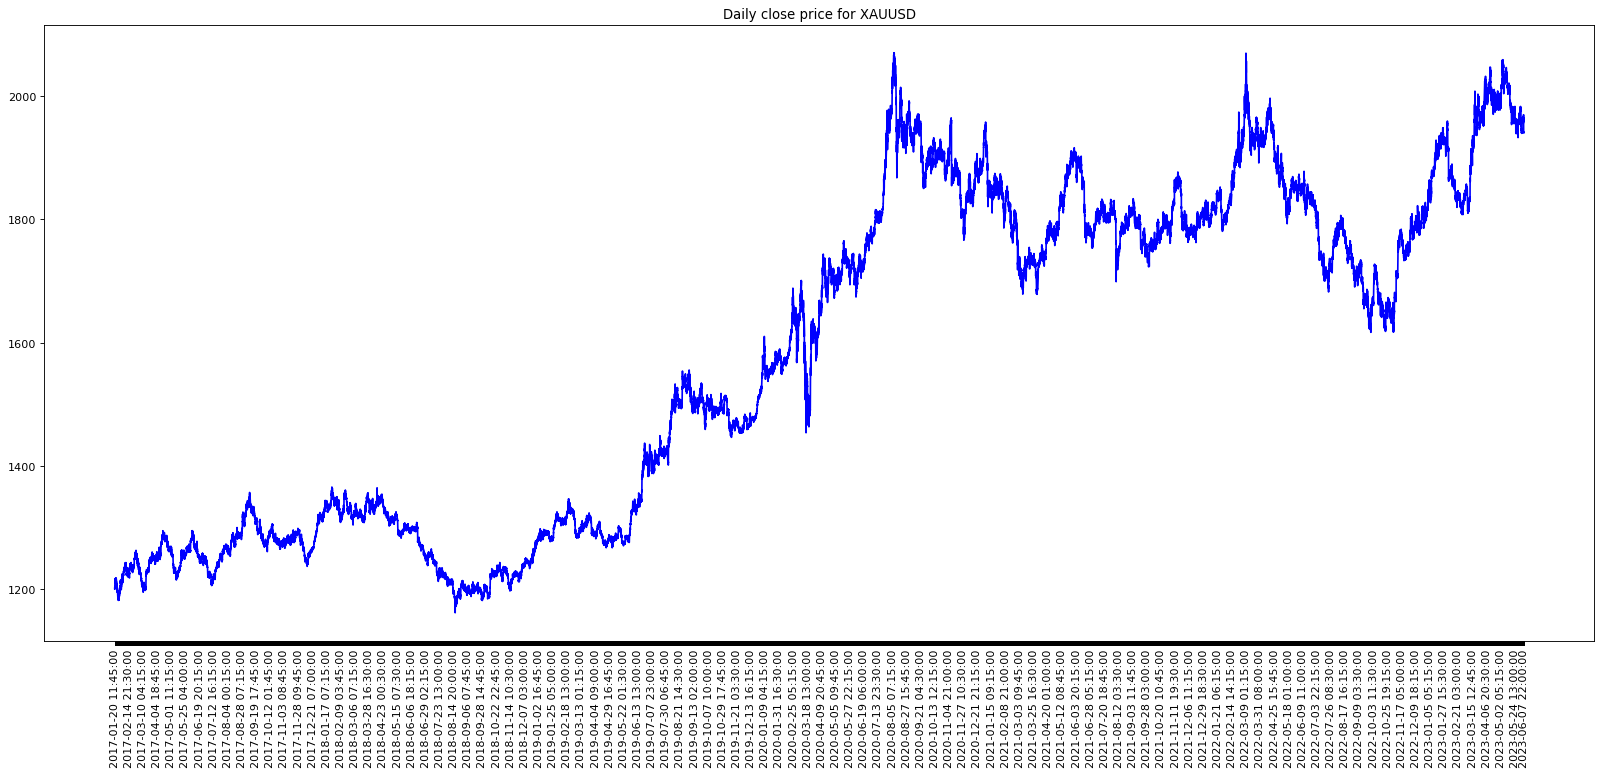

In [5]:
dates =list(data['time'])
# plotting the data
fig = figure(figsize=(25, 10), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(dates, data['close'], color='b')
xticks = [dates[i] if ((i%1500==0 and (len(dates)-i) > 10) or i==len(dates)-1) else None for i in range(len(dates))]
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for XAUUSD")
plt.show()

In [2]:
# Remove the 'time' column as it is non-numeric
# data = data.drop(['time'], axis=1)

# Normalize your data
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data_normalized, test_size=0.2, shuffle=False)


NameError: name 'data' is not defined

In [5]:
data_normalized

,open,high,low,close,tick_volume,MA_daily,MA_weekly,RSI,BB_High,BB_Low,MACD
0,0.041694,0.038345,0.043395,0.042925,0.116877,0.035320,0.000000,0.364338,0.035729,0.037453,0.571380
1,0.043004,0.039497,0.044066,0.044026,0.131291,0.035251,0.000338,0.446726,0.034572,0.037852,0.576324
2,0.044104,0.040023,0.045552,0.044400,0.094663,0.035198,0.000676,0.472327,0.033448,0.038331,0.581343
3,0.044478,0.040703,0.045893,0.044114,0.104273,0.035149,0.001009,0.454894,0.032657,0.038627,0.585113
4,0.044203,0.039497,0.044099,0.042407,0.115938,0.035074,0.001331,0.365197,0.031830,0.038835,0.585168
...,...,...,...,...,...,...,...,...,...,...,...
149613,0.879509,0.872338,0.880435,0.879372,0.014503,0.886623,0.891744,0.427044,0.875765,0.883300,0.598855
149614,0.879267,0.871888,0.879808,0.878844,0.023040,0.886522,0.891753,0.406951,0.875599,0.883106,0.597109
149615,0.878749,0.871844,0.880259,0.878921,0.006280,0.886426,0.891768,0.411209,0.875342,0.883008,0.596088
149616,0.878815,0.872163,0.880413,0.879592,0.003464,0.886374,0.891783,0.448686,0.875141,0.882987,0.596771


In [7]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length].values
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 100
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


In [6]:
class ForexPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(ForexPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred



In [29]:
with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()


RuntimeError: shape '[1, 5, 1]' is invalid for input of size 55

In [9]:
# device agnostic code.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
# Instantiate the LSTM model
input_size = X_train_seq.shape[2]
hidden_size = 64
output_size = 1
model = LSTMmodel(input_size, hidden_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/200, Loss: 0.0579
Epoch 2/200, Loss: 0.0146
Epoch 3/200, Loss: 0.0096
Epoch 4/200, Loss: 0.0089
Epoch 5/200, Loss: 0.0097
Epoch 6/200, Loss: 0.0085
Epoch 7/200, Loss: 0.0087
Epoch 8/200, Loss: 0.0081
Epoch 9/200, Loss: 0.0085
Epoch 10/200, Loss: 0.0096
Epoch 11/200, Loss: 0.0084
Epoch 12/200, Loss: 0.0080
Epoch 13/200, Loss: 0.0079
Epoch 14/200, Loss: 0.0080
Epoch 15/200, Loss: 0.0093
Epoch 16/200, Loss: 0.0076
Epoch 17/200, Loss: 0.0076
Epoch 18/200, Loss: 0.0075
Epoch 19/200, Loss: 0.0077
Epoch 20/200, Loss: 0.0070
Epoch 21/200, Loss: 0.0069
Epoch 22/200, Loss: 0.0067
Epoch 23/200, Loss: 0.0076
Epoch 24/200, Loss: 0.0081
Epoch 25/200, Loss: 0.0079
Epoch 26/200, Loss: 0.0080
Epoch 27/200, Loss: 0.0077
Epoch 28/200, Loss: 0.0079
Epoch 29/200, Loss: 0.0076
Epoch 30/200, Loss: 0.0073
Epoch 31/200, Loss: 0.0064
Epoch 32/200, Loss: 0.0062
Epoch 33/200, Loss: 0.0057
Epoch 34/200, Loss: 0.0045
Epoch 35/200, Loss: 0.0054
Epoch 36/200, Loss: 0.0045
Epoch 37/200, Loss: 0.0041
Epoch 38/2

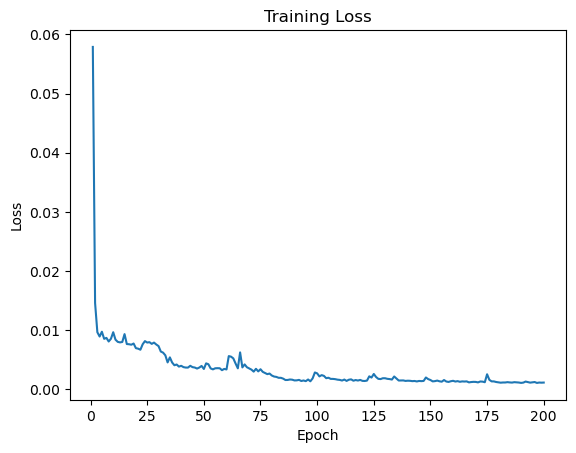

In [11]:
# Training the model
epochs = 100
model.train()
loss_values = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Plotting the epoch-loss graph
plt.plot(range(1, epochs+1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [54]:
# Evaluate the model
model.eval()
predictions = []
true_values = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_values.extend(targets.squeeze().cpu().numpy())

# Inverse transform the predictions and true values
y_pred = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
y_true = scaler.inverse_transform(np.array(true_values).reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 0.0070


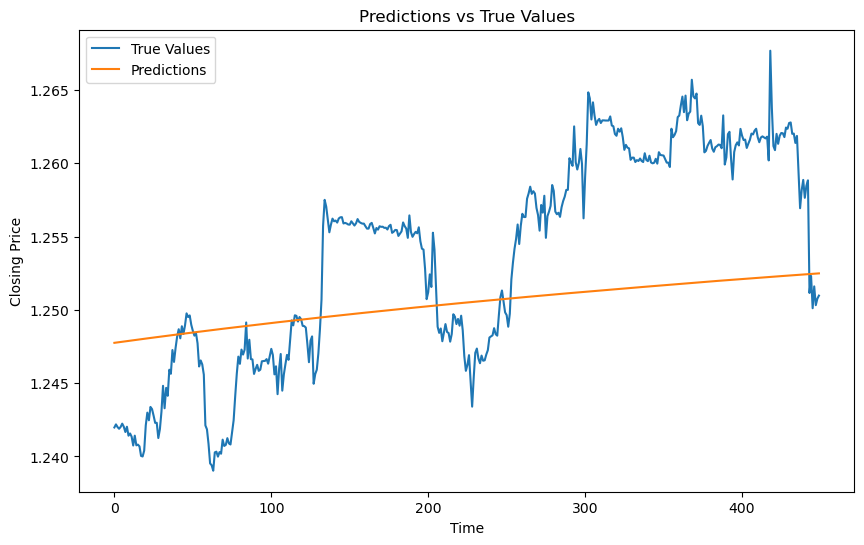

In [55]:
import matplotlib.pyplot as plt

# Plot predictions and true values
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True Values')
plt.plot(y_pred, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Predictions vs True Values')
plt.legend()
plt.show()


In [16]:
# Define LSTM model for predicting only close price
class ClosePredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(ClosePredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hiddenwhat )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred


In [20]:
# device agnostic code.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')